<img src="./unal.png" align=left width="150" height="150"></img>



$\,$
---

<h2 align="center"> DATOS DE BATEADORES DE LAS GRANDES LIGAS DE BÉISBOL DE LAS TEMPORADAS 1986 y 1987.</h2>
<h3 align="center">Métodos ensamble de regresión. Gradient Boosting</h3>


$\;$

---

# Boosting

Boosting funciona de manera parecida al bagging en cuanto a que combina un gran número de árboles, a excepción de que los árboles se construyen de manera secuencial: cada árbol se genera usando información, concretamente los residuos, de árboles previamente generados, en lugar de utilizar la variable respuesta (por ello suelen ser suficientes árboles más pequeños, en lugar de un gran árbol que pueda sobreajustarse a los datos). Otra diferencia es que boosting no utiliza remuestreo por bootstrapping, sino que cada árbol se genera utilizando una versión modificada del set de datos original. Algunos parámetros principales del algoritmo son:

• **Número de árboles (B).** A diferencia del bagging y random forests, boosting puede sobreajustarse a los datos si el número de árboles es demasiado alto (aunque en caso de darse, aparece lentamente). B se selecciona por validación cruzada.

• **Número de divisiones (d)** en cada árbol, que controla el nivel de complejidad. Un valor de d=1 (cada árbol contiene una única división, es decir, un único predictor) suele dar buenos resultados.

• **Parámetro de penalización ($\lambda$)**, que controla el ritmo con el que boosting aprende. Valores comunes para este parámetro suelen ser 0,01 o 0,001, aunque la decisión depende del problema en cuestión. Por ejemplo, un valor muy pequeño de λ puede requerir un número elevado de árboles para conseguir buenos resultados.

Algunos de los algoritmos de boosting más utilizados son:

* AdaBoost

* Gradient Boosting

* Stochastic Gradient Boosting

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import tree, preprocessing, model_selection, ensemble
from sklearn.tree import export_graphviz 
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, mean_squared_error, make_scorer, plot_confusion_matrix, classification_report
from sklearn import metrics

In [34]:
datos_hitters = pd.read_csv('Hitters.csv')

print('Filas:', datos_hitters.shape[0], 'Variables:', datos_hitters.shape[1])
print(type(datos_hitters))
print(datos_hitters.head())

Filas: 322 Variables: 20
<class 'pandas.core.frame.DataFrame'>
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
0    293    66      1    30   29     14      1     293     66       1     30   
1    315    81      7    24   38     39     14    3449    835      69    321   
2    479   130     18    66   72     76      3    1624    457      63    224   
3    496   141     20    65   78     37     11    5628   1575     225    828   
4    321    87     10    39   42     30      2     396    101      12     48   

   CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague  
0    29      14      A        E      446       33      20     NaN         A  
1   414     375      N        W      632       43      10   475.0         N  
2   266     263      A        W      880       82      14   480.0         A  
3   838     354      N        E      200       11       3   500.0         N  
4    46      33      N        E      805       40       4    91.5 

In [35]:
datos_hitters.describe()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.00000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,263.000000
mean,380.928571,101.024845,10.770186,50.909938,48.027950,38.742236,7.444099,2648.68323,717.571429,69.490683,358.795031,330.118012,260.239130,288.937888,106.913043,8.040373,535.925882
std,153.404981,46.454741,8.709037,26.024095,26.166895,21.639327,4.926087,2324.20587,654.472627,86.266061,334.105886,333.219617,267.058085,280.704614,136.854876,6.368359,451.118681
min,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,19.00000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.500000
25%,255.250000,64.000000,4.000000,30.250000,28.000000,22.000000,4.000000,816.75000,209.000000,14.000000,100.250000,88.750000,67.250000,109.250000,7.000000,3.000000,190.000000
50%,379.500000,96.000000,8.000000,48.000000,44.000000,35.000000,6.000000,1928.00000,508.000000,37.500000,247.000000,220.500000,170.500000,212.000000,39.500000,6.000000,425.000000
75%,512.000000,137.000000,16.000000,69.000000,64.750000,53.000000,11.000000,3924.25000,1059.250000,90.000000,526.250000,426.250000,339.250000,325.000000,166.000000,11.000000,750.000000
max,687.000000,238.000000,40.000000,130.000000,121.000000,105.000000,24.000000,14053.00000,4256.000000,548.000000,2165.000000,1659.000000,1566.000000,1378.000000,492.000000,32.000000,2460.000000


In [36]:
# Datos faltantes (NaN) por variable
print(datos_hitters.isna().sum(axis = 0))

# Eliminamos los 59 registros con datos faltantes en "Salary"
datos_hitters = datos_hitters.dropna()
print('Tras eliminar NaNs\n','Filas:', datos_hitters.shape[0], 'Variables:', datos_hitters.shape[1])

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64
Tras eliminar NaNs
 Filas: 263 Variables: 20


In [37]:
print(datos_hitters.isna().sum(axis = 0))

AtBat        0
Hits         0
HmRun        0
Runs         0
RBI          0
Walks        0
Years        0
CAtBat       0
CHits        0
CHmRun       0
CRuns        0
CRBI         0
CWalks       0
League       0
Division     0
PutOuts      0
Assists      0
Errors       0
Salary       0
NewLeague    0
dtype: int64


Ya no se tienen datos faltantes.

#### Distribución de la variable respuesta "Salary"

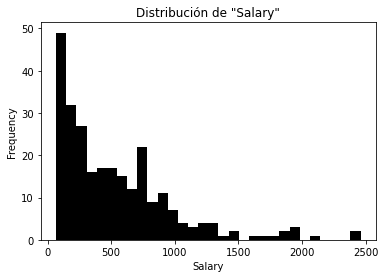

In [38]:
datos_hitters['Salary'].plot(kind='hist', bins=30, color='black')
plt.title('Distribución de "Salary"')
plt.xlabel('Salary')
plt.show()

In [39]:
# Aplicamos la transformación logarítmica a los datos de "Salary" para hacer su distribución mas normal
datos_hitters['Salary'] = np.log(datos_hitters['Salary'])

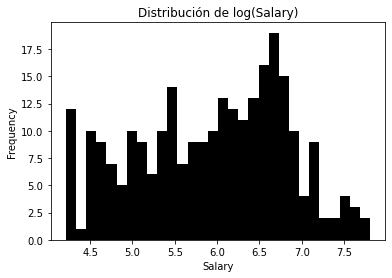

In [40]:
# Distribucion de la variable "Salary" transformada
datos_hitters['Salary'].plot(kind='hist', bins=30, color='black')
plt.title('Distribución de log(Salary)')
plt.xlabel('Salary')
plt.show()

In [41]:
# DIVISION MANUAL

X_train = datos_hitters.loc[:201, datos_hitters.columns != 'Salary']
y_train = datos_hitters.loc[:201, 'Salary']

X_test = datos_hitters.loc[201:, datos_hitters.columns != 'Salary']
y_test = datos_hitters.loc[201:, 'Salary']

In [42]:
# DIVISION ALEATORIA

# Separamos los predictores (X) de la variable respuesta (y)
#X = datos_hitters.loc[:, datos_hitters.columns != 'Salary']
#y = datos_hitters['Salary']

# Dividimos los datos en entrenamiento (80%) y test (20%) de forma aleatoria
#X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=0, test_size=0.2)

In [43]:
# Es necesario codificar las variables categorifcas "League", "NewLeague" y "Division" a numericas
cat = preprocessing.LabelEncoder()
for col in ['League', 'NewLeague', 'Division']:
    X_train.loc[:,col] = cat.fit_transform(X_train.loc[:,col])
    X_test.loc[:,col] = cat.fit_transform(X_test.loc[:,col])

### Importando clase GradientBoostingRegressor de la libreria sklearn.ensemble

In [26]:
from sklearn.ensemble import GradientBoostingRegressor

In [27]:
# Establecemos un grid con las combinaciones de valores que queremos evaluar. Combinaciones resultantes=3^4=81
grid_hiperparametros = {'n_estimators': [100, 200, 300], #nº de etapas de boosting
                        'learning_rate': [0.01, 0.1, 0.15], #reduce la contribucion de cada arbol por este valor 
                        'max_features': [4, 5, 6], #nº de variables a tener en cuenta para las divisiones (mtry en R)
                        'min_samples_split': [5, 10, 15]} #nº mínimo de observaciones necesarias para dividir un nodo interno (n.minobsinnode en R)


# Definimos las métricas de interés
metricas = {'r2':make_scorer(metrics.r2_score), 'mse': make_scorer(mean_squared_error)}

# Definimos los parámetros de búsqueda por validación cruzada
busqueda_grid = GridSearchCV(estimator = ensemble.GradientBoostingRegressor(criterion='mse', 
                                                                            loss='ls', #funcion a optimizar = least squares
                                                                            random_state=0), 
                             param_grid = grid_hiperparametros, 
                             cv = 10, #folds
                             #return_train_score = True,
                             scoring = metricas,
                             refit = "mse",
                             n_jobs = -1) 

# Aplicamos la busqueda
busqueda_grid.fit(X_train, y_train)

# Mejores hiperparametros sobre los datos hold-out y métricas de validación cruzada
print('Conjunto de hiperparámetros óptimo:\n', busqueda_grid.best_params_,
     '\nMSE +- std =', round(busqueda_grid.cv_results_['mean_test_mse'][busqueda_grid.best_index_],3),
     '+-', round(busqueda_grid.cv_results_['std_test_mse'][busqueda_grid.best_index_],3),
     '\nR^2 =', round(busqueda_grid.cv_results_['mean_test_r2'][busqueda_grid.best_index_],3),
     '+-', round(busqueda_grid.cv_results_['std_test_r2'][busqueda_grid.best_index_],3))

Conjunto de hiperparámetros óptimo:
 {'learning_rate': 0.01, 'max_features': 4, 'min_samples_split': 15, 'n_estimators': 100} 
MSE +- std = 0.008 +- 0.003 
R^2 = 0.693 +- 0.085


In [28]:
# Ajustamos el modelo GradientBoosting usando los hiperparametros optimos obtenidos
modelo_boostingR = ensemble.GradientBoostingRegressor(criterion='mse', # criterio para la division
                                                      n_estimators = 100,
                                                      max_features = 4, 
                                                      learning_rate = 0.01,
                                                      min_samples_split = 15,
                                                      random_state = 0) # semilla
                                                     

# Entrenamos el modelo con los datos de entrenamiento 
modelo_boostingR.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=3,
                          max_features=4, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=15,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

### Evaluación

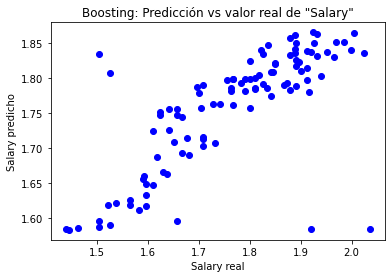

In [29]:
# Obtenemos las predicciones del modelo sobre los datos de test
y_pred = modelo_boostingR.predict(X_test)

plt.scatter(y_test, y_pred, color = 'blue') 
plt.title('Boosting: Predicción vs valor real de "Salary"')
plt.xlabel('Salary real')
plt.ylabel('Salary predicho')
plt.show()

In [30]:
# TEST

# Métricas en test
print('Métricas en test:',
      '\nMAE =', round(metrics.mean_absolute_error(y_test, y_pred),3),
      '\nMMSE =', round(metrics.mean_squared_error(y_test, y_pred),3),
      '\nRMSE =', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),3),
      '\nR^2 =', round(modelo_boostingR.score(X_test, y_test),3))

Métricas en test: 
MAE = 0.074 
MMSE = 0.01 
RMSE = 0.102 
R^2 = 0.519


In [31]:
print(modelo_boostingR.score(X_train, y_train))
print(modelo_boostingR.score(X_test, y_test))

0.7561616822498293
0.5191604039711277


#### Importancia de las variables

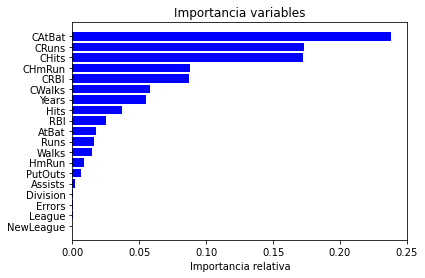

In [44]:
# Recuperamos los valores de importancia del modelo ajustado
importancias = modelo_boostingR.feature_importances_
# Ordenamos los valores de importancia en orden descendiente
indices = np.argsort(importancias)

plt.title('Importancia variables')
plt.barh(range(len(indices)), importancias[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Importancia relativa')
plt.show()